In [2]:
# Basic tools
import os
import sys
import re

# Data tools
import numpy as np
import pandas as pd
from scipy.stats import norm

# Scraping tools
import requests
from bs4 import BeautifulSoup

# Viz tools
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# NLP tools
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals import joblib
from gensim.models import KeyedVectors

# Local
## Allow local relative imports
module_path = os.path.abspath('..')
include_path = os.path.join(module_path, 'include')
data_path = os.path.join(module_path, 'data')
models_path = os.path.join(module_path, 'models')
eda_path = os.path.join(module_path, 'eda')
if include_path not in sys.path:
    sys.path.append(include_path)
from my_nlp import Tokenizer

In [3]:
def mean_filtered(embed, doc, vocab_weights = None):
    embed_filtered = [x for x in doc.split() if x in embed.vocab]
    if len(embed_filtered) > 0:
        if vocab_weights is None:
            return embed[embed_filtered].mean(axis = 0)
        else:
            weight_filtered = [x for x in embed_filtered if x in vocab_weights]
            if len(weight_filtered) > 0:
                weights = np.array([vocab_weights[x] for x in weight_filtered])
                return weights.dot(wiki2vec_embed[weight_filtered]) / weights.sum()
            else:
                return np.zeros(embed.vector_size, dtype = np.float32)
    else:
        return np.zeros(embed.vector_size, dtype = np.float32)

In [4]:
def precision_recall(target_relevant_inds, target_selected_inds):
    n_selected = target_selected_inds.shape[1]
    n_relevant = len(target_relevant_inds)
    n_selected_relevant = intersect_vectorizer(target_relevant_inds, target_selected_inds)

    precision = n_selected_relevant / n_selected
    recall = n_selected_relevant / n_relevant
    return [precision, recall]

In [5]:
def populate_dataframe(vectorizer, origin_title, target_title,
                       origin_sents, target_sents,
                       origin_relevant_inds, target_relevant_inds,
                       n_selected = 10, scale = 10):
    sim_mat = cosine_similarity(*[vectorizer(x) for x in [origin_sents, target_sents]])
    sim_mat_T = sim_mat.T
    
    n_origin_relevent_inds = len(origin_relevant_inds)
    linked_titles = [np.array([x] * n_origin_relevent_inds) for x in [origin_title, target_title]]
    
    target_selected_inds_link = sim_mat[origin_relevant_inds].argsort(axis = 1)[:, :n_selected]
    target_selected_inds_wavg = weight_vectorizer(origin_sents, origin_relevant_inds, scale).dot(sim_mat).argsort(axis = 1)[:, :n_selected]
    target_selected_inds_summ = np.tile(np.arange(n_selected), (len(origin_relevant_inds), 1))
    target_selected_inds_rand = np.random.choice(np.arange(len(target_sents)), size = (n_origin_relevent_inds, n_selected))
    
    target_precision_recall = []
    for x in [target_selected_inds_link, target_selected_inds_wavg,
              target_selected_inds_summ, target_selected_inds_rand]:
        target_precision_recall.extend(precision_recall(target_relevant_inds, x))
    
    target_df = pd.DataFrame(linked_titles + target_precision_recall, index = ['origin_title', 'target_title',
                                                                               'link_precision', 'link_recall',
                                                                               'wavg_precision', 'wavg_recall',
                                                                               'summ_precision', 'summ_recall',
                                                                               'rand_precision', 'rand_recall']).T
    
    n_target_relevent_inds = len(target_relevant_inds)
    linked_titles = [np.array([x] * n_target_relevent_inds) for x in [target_title, origin_title]]
    
    origin_selected_inds_link = sim_mat_T[target_relevant_inds].argsort(axis = 1)[:, :n_selected]
    origin_selected_inds_wavg = weight_vectorizer(target_sents, target_relevant_inds, scale).dot(sim_mat_T).argsort(axis = 1)[:, :n_selected]
    origin_selected_inds_summ = np.tile(np.arange(n_selected), (len(target_relevant_inds), 1))
    origin_selected_inds_rand = np.random.choice(np.arange(len(origin_sents)), size = (len(target_relevant_inds), n_selected))    
    
    origin_precision_recall = []
    for x in [origin_selected_inds_link, origin_selected_inds_wavg,
              origin_selected_inds_summ, origin_selected_inds_rand]:
        origin_precision_recall.extend(precision_recall(origin_relevant_inds, x))
    
    origin_df = pd.DataFrame(linked_titles + origin_precision_recall, index = ['origin_title', 'target_title',
                                                                               'link_precision', 'link_recall',
                                                                               'wavg_precision', 'wavg_recall',
                                                                               'summ_precision', 'summ_recall',
                                                                               'rand_precision', 'rand_recall']).T
    
    return pd.concat([target_df, origin_df], axis = 0, ignore_index = True)

In [225]:
tok = Tokenizer()
sess = requests.Session()
wapi_url = "https://en.wikipedia.org/w/api.php"
tfidf_vectorizer = joblib.load(models_path + '/tfidf/enwiki-latest-all-tfidf_vectorizer.joblib')
wiki2vec_embed = KeyedVectors.load(models_path + '/wiki2vec/en.model.kv')
wiki2vec_vectorizer = np.vectorize(lambda x: mean_filtered(wiki2vec_embed, x), signature = '()->(n)')
tfidf_wiki2vec_vectorizer = np.vectorize(lambda x: mean_filtered(wiki2vec_embed, x, vocab_weights = tfidf_vectorizer.vocabulary_), signature = '()->(n)')
weight_vectorizer = np.vectorize(lambda x, y, z: norm.pdf(range(x.size), loc = y, scale = z), signature = '(m),(),()->(n)')
intersect_vectorizer = np.vectorize(lambda x, y: np.intersect1d(x, y).size, signature = '(m),(n)->()')

In [370]:
bilinks_df = pd.read_csv(data_path + '/clickstream-enwiki-2018-08-bilinks_sample.tsv', sep = '\t')

In [5]:
bilink_ind = 0

while True:
    origin_title, target_title = bilinks_df[['origin_title', 'target_title']].iloc[bilink_ind].tolist()

    origin_wapi_params = {
        'action': "parse",
        'maxlag': 5,
        'page': origin_title,
        'prop': "text",
        'contentformat': "text/plain",
        'format': "json"
    }

    try:
        origin_data = sess.get(url = wapi_url, params = origin_wapi_params).json()
        origin_title_norm = origin_data['parse']['title']
        origin_text = origin_data['parse']['text']['*']
    except KeyError:
        continue

    origin_soup = BeautifulSoup(origin_text, 'html5lib')

    target_wapi_params = {
        'action': "parse",
        'maxlag': 5,
        'page': target_title,
        'prop': "text",
        'format': "json"
    }

    try:
        target_data = sess.get(url = wapi_url, params = target_wapi_params).json()
        target_title_norm = target_data['parse']['title']
        target_text = target_data['parse']['text']['*']
    except KeyError:
        continue
    
    target_soup = BeautifulSoup(target_text, 'html5lib')
    
    break

In [102]:
origin_sents = []
origin_relevant_inds = []
sent_ind = 0
for p in origin_soup.find_all('p'):
    for p_split in p.decode_contents().split('\n'):
        for sent in nltk.sent_tokenize(p_split):
            sent_content = BeautifulSoup(sent, 'html5lib').body.get_text().replace(u'\xa0', u' ')
            sent_content = re.sub('\[.*?\]', '', sent_content)
            sent_content = ' '.join(tok.load(sent_content).word_tokenize(lemmatize = True).word_tokens)
            if len(sent_content) > 0:
                if target_title_norm in sent:
                    origin_relevant_inds.append(sent_ind)
                origin_sents.append(sent_content)
                sent_ind += 1
origin_sents = np.array(origin_sents)

target_sents = []
target_relevant_inds = []
sent_ind = 0
for p in target_soup.find_all('p'):
    for p_split in p.decode_contents().split('\n'):
        for sent in nltk.sent_tokenize(p_split):
            sent_content = BeautifulSoup(sent, 'html5lib').body.get_text().replace(u'\xa0', u' ')
            sent_content = re.sub('\[.*?\]', '', sent_content)
            sent_content = ' '.join(tok.load(sent_content).word_tokenize(lemmatize = True).word_tokens)
            if len(sent_content) > 0:
                if origin_title_norm in sent:
                    target_relevant_inds.append(sent_ind)
                target_sents.append(sent_content)
                sent_ind += 1
target_sents = np.array(target_sents)

In [288]:
if (origin_sents.size > 0) and (len(origin_relevant_inds) > 0) and (target_sents.size > 0) and (len(target_relevant_inds) > 0):
    wiki2vec_df = populate_dataframe(wiki2vec_vectorizer, origin_title, target_title,
                                     origin_sents, target_sents,
                                     origin_relevant_inds, target_relevant_inds,
                                     n_selected = 10, scale = 10)

    tfidf_wiki2vec_df = populate_dataframe(tfidf_wiki2vec_vectorizer, origin_title, target_title,
                                           origin_sents, target_sents,
                                           origin_relevant_inds, target_relevant_inds,
                                           n_selected = 10, scale = 10)
    tfidf_wiki2vec_df = tfidf_wiki2vec_df.rename(columns = dict([(x, 'tfidf_' + x) for x in tfidf_wiki2vec_df.columns if '_title' not in x]))

    valid_df = pd.concat([wiki2vec_df, tfidf_wiki2vec_df.drop(columns = ['origin_title', 'target_title'])], axis = 1)

In [6]:
valid_df = pd.read_csv(data_path + '/clickstream-enwiki-2018-08-validation.tsv', sep = '\t')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


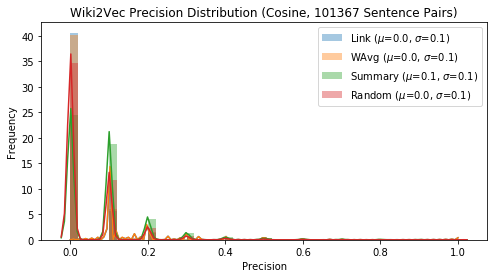

In [19]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.cos_link_precision.mean(), valid_df.cos_link_precision.std()
sns.distplot(valid_df.cos_link_precision, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_wavg_precision.mean(), valid_df.cos_wavg_precision.std()
sns.distplot(valid_df.cos_wavg_precision, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_summ_precision.mean(), valid_df.cos_summ_precision.std()
sns.distplot(valid_df.cos_summ_precision, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_rand_precision.mean(), valid_df.cos_rand_precision.std()
sns.distplot(valid_df.cos_rand_precision, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("Wiki2Vec Precision Distribution (Cosine, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Precision")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/cos_wiki2vec_precision.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


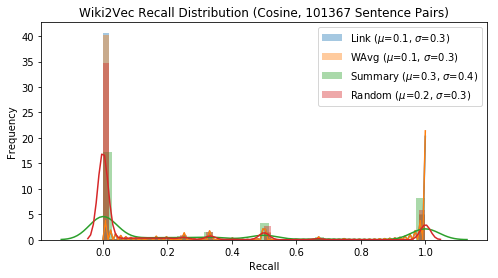

In [18]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.cos_link_recall.mean(), valid_df.cos_link_recall.std()
sns.distplot(valid_df.cos_link_recall, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_wavg_recall.mean(), valid_df.cos_wavg_recall.std()
sns.distplot(valid_df.cos_wavg_recall, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_summ_recall.mean(), valid_df.cos_summ_recall.std()
sns.distplot(valid_df.cos_summ_recall, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_rand_recall.mean(), valid_df.cos_rand_recall.std()
sns.distplot(valid_df.cos_rand_recall, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("Wiki2Vec Recall Distribution (Cosine, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Recall")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/cos_wiki2vec_recall.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


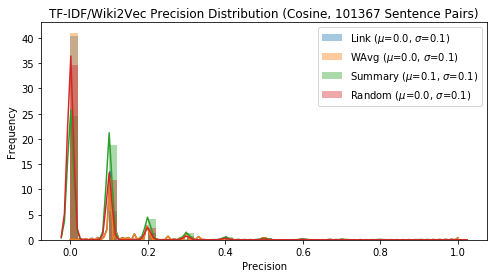

In [10]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.cos_tfidf_link_precision.mean(), valid_df.cos_tfidf_link_precision.std()
sns.distplot(valid_df.cos_tfidf_link_precision, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_tfidf_wavg_precision.mean(), valid_df.cos_tfidf_wavg_precision.std()
sns.distplot(valid_df.cos_tfidf_wavg_precision, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_tfidf_summ_precision.mean(), valid_df.cos_tfidf_summ_precision.std()
sns.distplot(valid_df.cos_tfidf_summ_precision, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_tfidf_rand_precision.mean(), valid_df.cos_tfidf_rand_precision.std()
sns.distplot(valid_df.cos_tfidf_rand_precision, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("TF-IDF/Wiki2Vec Precision Distribution (Cosine, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Precision")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/cos_tfidf_wiki2vec_precision.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


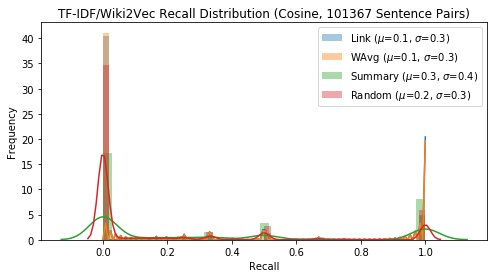

In [11]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.cos_tfidf_link_recall.mean(), valid_df.cos_tfidf_link_recall.std()
sns.distplot(valid_df.cos_tfidf_link_recall, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_tfidf_wavg_recall.mean(), valid_df.cos_tfidf_wavg_recall.std()
sns.distplot(valid_df.cos_tfidf_wavg_recall, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_tfidf_summ_recall.mean(), valid_df.cos_tfidf_summ_recall.std()
sns.distplot(valid_df.cos_tfidf_summ_recall, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.cos_tfidf_rand_recall.mean(), valid_df.cos_tfidf_rand_recall.std()
sns.distplot(valid_df.cos_tfidf_rand_recall, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("TF-IDF/Wiki2Vec Recall Distribution (Cosine, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Recall")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/cos_tfidf_wiki2vec_recall.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


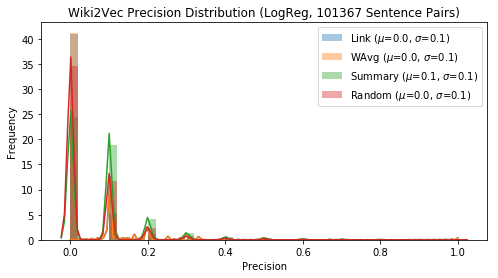

In [12]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.logreg_link_precision.mean(), valid_df.logreg_link_precision.std()
sns.distplot(valid_df.logreg_link_precision, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_wavg_precision.mean(), valid_df.logreg_wavg_precision.std()
sns.distplot(valid_df.logreg_wavg_precision, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_summ_precision.mean(), valid_df.logreg_summ_precision.std()
sns.distplot(valid_df.logreg_summ_precision, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_rand_precision.mean(), valid_df.logreg_rand_precision.std()
sns.distplot(valid_df.logreg_rand_precision, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("Wiki2Vec Precision Distribution (LogReg, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Precision")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/logreg_wiki2vec_precision.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


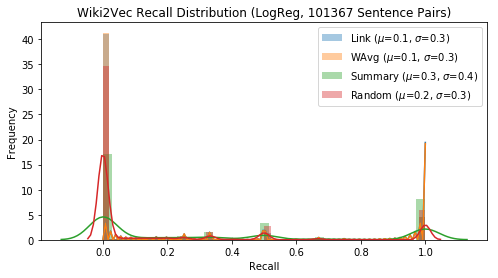

In [13]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.logreg_link_recall.mean(), valid_df.logreg_link_recall.std()
sns.distplot(valid_df.logreg_link_recall, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_wavg_recall.mean(), valid_df.logreg_wavg_recall.std()
sns.distplot(valid_df.logreg_wavg_recall, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_summ_recall.mean(), valid_df.logreg_summ_recall.std()
sns.distplot(valid_df.logreg_summ_recall, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_rand_recall.mean(), valid_df.logreg_rand_recall.std()
sns.distplot(valid_df.logreg_rand_recall, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("Wiki2Vec Recall Distribution (LogReg, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Recall")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/logreg_wiki2vec_recall.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


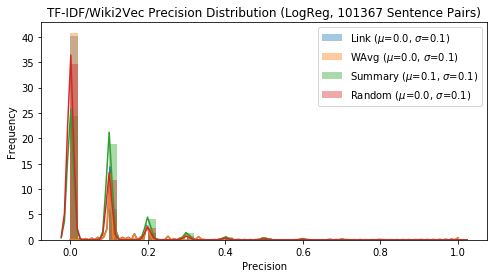

In [14]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.logreg_tfidf_link_precision.mean(), valid_df.logreg_tfidf_link_precision.std()
sns.distplot(valid_df.logreg_tfidf_link_precision, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_tfidf_wavg_precision.mean(), valid_df.logreg_tfidf_wavg_precision.std()
sns.distplot(valid_df.logreg_tfidf_wavg_precision, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_tfidf_summ_precision.mean(), valid_df.logreg_tfidf_summ_precision.std()
sns.distplot(valid_df.logreg_tfidf_summ_precision, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_tfidf_rand_precision.mean(), valid_df.logreg_tfidf_rand_precision.std()
sns.distplot(valid_df.logreg_tfidf_rand_precision, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("TF-IDF/Wiki2Vec Precision Distribution (LogReg, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Precision")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/logreg_tfidf_wiki2vec_precision.png')

/usr/local/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


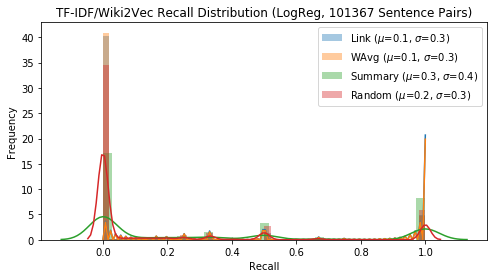

In [15]:
fig = plt.figure(figsize = (8, 4))
mu, sigma = valid_df.logreg_tfidf_link_recall.mean(), valid_df.logreg_tfidf_link_recall.std()
sns.distplot(valid_df.logreg_tfidf_link_recall, label = "Link ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_tfidf_wavg_recall.mean(), valid_df.logreg_tfidf_wavg_recall.std()
sns.distplot(valid_df.logreg_tfidf_wavg_recall, label = "WAvg ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_tfidf_summ_recall.mean(), valid_df.logreg_tfidf_summ_recall.std()
sns.distplot(valid_df.logreg_tfidf_summ_recall, label = "Summary ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
mu, sigma = valid_df.logreg_tfidf_rand_recall.mean(), valid_df.logreg_tfidf_rand_recall.std()
sns.distplot(valid_df.logreg_tfidf_rand_recall, label = "Random ($\mu$={:.1f}, $\sigma$={:.1f})".format(mu, sigma))
plt.legend()
plt.title("TF-IDF/Wiki2Vec Recall Distribution (LogReg, {} Sentence Pairs)".format(valid_df.shape[0]))
plt.xlabel("Recall")
plt.ylabel("Frequency")
fig.savefig(eda_path + '/logreg_tfidf_wiki2vec_recall.png')